# Exploration

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

In [2]:
from trajtool import TrajTool
tt = TrajTool()

## 1 Braking parameters calculation

In [3]:
models = ['Sylphy', 'Corolla', 'Avalon', 'TiguanL', 'Ei5', 'ModelY']
drivers = ['DRIVER1', 'DRIVER2']

In [4]:
# load trajectory
read_path = 'data/2-mapmatched/matched/'
traj_files = os.listdir(read_path)
trajs = {}
for traj_file in traj_files:
    key = traj_file.split('.')[0]
    trajs[key] = pd.read_csv(read_path + traj_file)

In [3]:
l = 0
for key, traj in trajs.items():
    l += traj.shape[0]
l

40704

In [4]:
l / 12

3392.0

In [5]:
# deceleration and braking dataset
decel_set = pd.read_csv("data/3-braking/decel_set.csv")

### 1.1 Amount & intensity

In [6]:
model_driver_params = []

for key, df in trajs.items():
    model, driver = key.split('-')
    mileage_dict = tt.cal_mileage(df, 'lon', 'lat')
    total_mileage = mileage_dict[0] / 1000
    total_time = df['sec'].iloc[-1] + 1
    average_speed = df['speed[km/h]'].mean()
    model_driver_params.append({
        'model': model,
        'driver': driver,
        'mileage[km]': total_mileage,
        'duration[s]': total_time,
        'avg_speed[km/h]': average_speed,
    })

model_driver_params = pd.DataFrame(model_driver_params)

In [7]:
braking_trajs = decel_set[decel_set['braking'] == 1].copy()
braking_trajs_groups = decel_set.groupby(by=['model', 'driver', 'event_id'])

def cal_braking_params(group):

    # initial speed
    initial_speed = group['speed[km/h]'].iloc[0]

    # average acceleration
    braking_deceleration = group['acc[m/s2]'].mean()

    # braking duration
    braking_duration = group['braking'].sum()

    # regenerative trajectory counts
    reg_braking_duration = group['reg'].sum()

    # road type
    highway = group['highway'].mode().values[0]

    # weight
    weight = group['weight/kg'].mode().values[0]

    return pd.Series({
        'braking_t[s]': braking_duration,
        'init_speed[km/h]': initial_speed,
        'decel[m/s2]': braking_deceleration,
        'reg_braking_t[s]': reg_braking_duration,
        'highway': highway,
        'weight': weight,
    })

# event-based aggregation
model_driver_events = braking_trajs_groups.apply(cal_braking_params)
model_driver_events.reset_index(inplace=True)

In [ ]:
# model_driver_events.to_csv("data/3-braking/model_driver_events.csv", index=False)

In [8]:
import numpy as np

model_driver_agg = model_driver_events.groupby(['model', 'driver']).agg({
    'event_id': 'nunique',  # Number of braking events
    'braking_t[s]': 'sum',  # Total braking time
    'init_speed[km/h]': 'mean',  # Average initial speed
    'decel[m/s2]': 'mean',  # Average deceleration
    'reg_braking_t[s]': 'sum'  # Total regenerative braking time
})

model_driver_agg.rename(columns={
    'event_id': 'braking_n',
    'braking_t[s]': 'braking_t[s]',
    'init_speed[km/h]': 'avg_init_speed[km/h]',
    'decel[m/s2]': 'avg_decel[m/s2]',
    'reg_braking_t[s]': 'reg_braking_t[s]'
}, inplace=True)

# Merge the aggregated results into model_driver_params
model_driver = pd.merge(model_driver_params, model_driver_agg, on=['model', 'driver'], how='left')

# Calculate braking ratio, braking frequency, and regenerative braking ratio
model_driver['avg_braking_t[s]'] = model_driver['braking_t[s]'] / model_driver['braking_n']
model_driver['braking_frac'] = model_driver['braking_t[s]'] / model_driver['duration[s]']
model_driver['reg_braking_frac'] = model_driver['reg_braking_t[s]'] / model_driver['duration[s]']
model_driver['braking_freq'] = model_driver['braking_n'] / model_driver['mileage[km]']
model_driver['model'] = pd.Categorical(model_driver['model'], categories=models, ordered=True)
model_driver = model_driver.sort_values(by='model').reset_index(drop=True)
model_driver

,model,driver,mileage[km],duration[s],avg_speed[km/h],braking_n,braking_t[s],avg_init_speed[km/h],avg_decel[m/s2],reg_braking_t[s],avg_braking_t[s],braking_frac,reg_braking_frac,braking_freq
0,Sylphy,DRIVER1,36.458082,3478,37.621901,208,848,57.096430,-0.265843,0,4.076923,0.243818,0.000000,5.705182
1,Sylphy,DRIVER2,36.421274,3284,39.753006,202,946,55.004777,-0.253577,0,4.683168,0.288063,0.000000,5.546209
2,Corolla,DRIVER1,36.466823,3497,37.330507,142,1154,56.889990,-0.253332,0,8.126761,0.329997,0.000000,3.893950
3,Corolla,DRIVER2,36.449888,3581,36.437568,156,1192,51.725285,-0.278145,0,7.641026,0.332868,0.000000,4.279849
4,Avalon,DRIVER1,36.363125,3057,42.767775,153,741,56.781037,-0.281370,0,4.843137,0.242395,0.000000,4.207559
5,Avalon,DRIVER2,36.432178,3167,41.143938,135,952,54.535192,-0.341654,0,7.051852,0.300600,0.000000,3.705516
6,TiguanL,DRIVER1,36.428059,3189,40.971752,158,809,58.264772,-0.282183,0,5.120253,0.253685,0.000000,4.337316
7,TiguanL,DRIVER2,36.453359,3527,37.080994,151,906,55.559611,-0.328169,0,6.000000,0.256876,0.000000,4.142279
8,Ei5,DRIVER1,36.358949,3627,35.886382,207,978,50.328334,-0.286342,458,4.724638,0.269644,0.126275,5.693234
9,Ei5,DRIVER2,36.371896,3249,40.137473,141,947,57.154624,-0.284664,330,6.716312,0.291474,0.101570,3.876619


### 1.2 Distributions

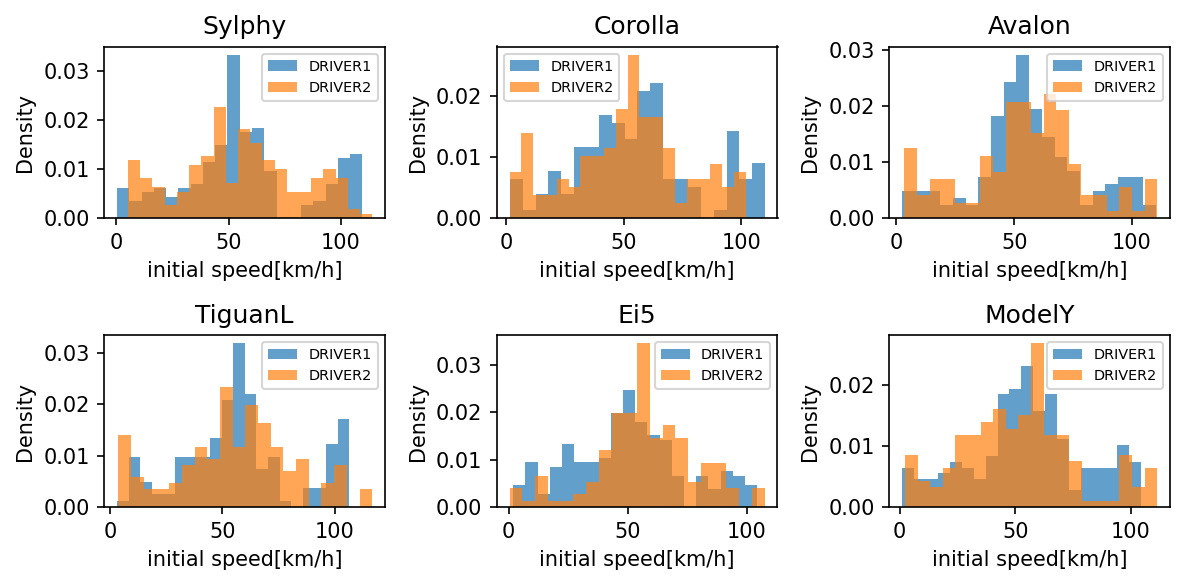

In [130]:
fig, axes = plt.subplots(2, 3, figsize=(8,4))
axes = axes.flatten()

for i, model in enumerate(models):
    model_data = model_driver_events[model_driver_events['model'] == model]
    driver_1_data = model_data[model_data['driver'] == drivers[0]]['init_speed[km/h]']
    driver_2_data = model_data[model_data['driver'] == drivers[1]]['init_speed[km/h]']

    axes[i].hist(driver_1_data, bins=20, density=True, alpha=0.7, label=drivers[0])
    axes[i].hist(driver_2_data, bins=20, density=True, alpha=0.7, label=drivers[1])
    axes[i].set_title(model)
    axes[i].set_xlabel('initial speed[km/h]')
    axes[i].set_ylabel('Density')
    axes[i].legend(fontsize='x-small')

plt.tight_layout()
plt.show()

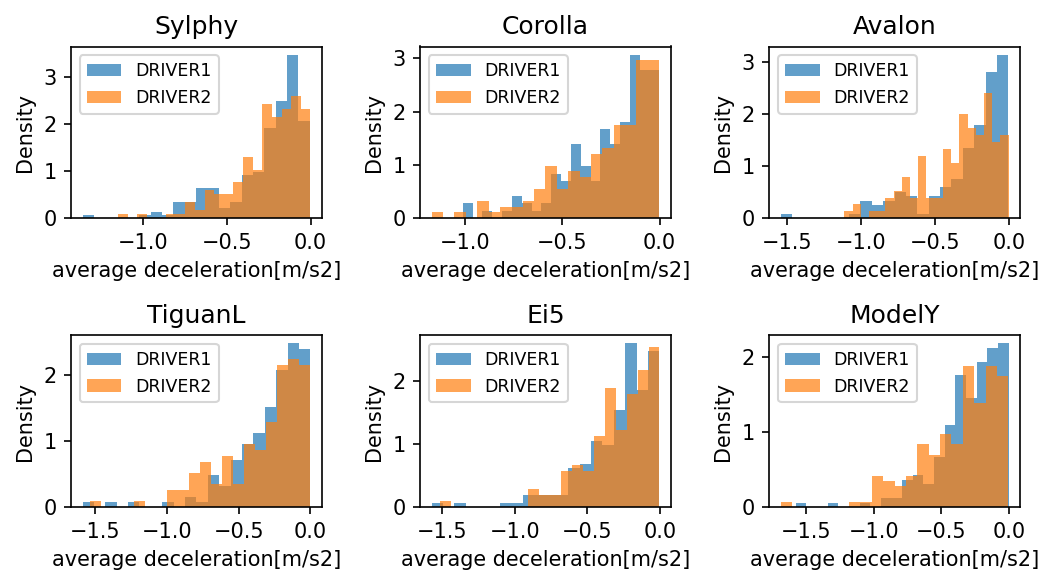

In [98]:
fig, axes = plt.subplots(2, 3, figsize=(7,4))
axes = axes.flatten()

for i, model in enumerate(models):
    model_data = model_driver_events[model_driver_events['model'] == model]
    driver_1_data = model_data[model_data['driver'] == drivers[0]]['decel[m/s2]']
    driver_2_data = model_data[model_data['driver'] == drivers[1]]['decel[m/s2]']

    axes[i].hist(driver_1_data, bins=20, density=True, alpha=0.7, label=drivers[0])
    axes[i].hist(driver_2_data, bins=20, density=True, alpha=0.7, label=drivers[1])
    axes[i].set_title(model)
    axes[i].set_xlabel('average deceleration[m/s2]')
    axes[i].set_ylabel('Density')
    axes[i].legend(fontsize='small')

plt.tight_layout()
plt.show()

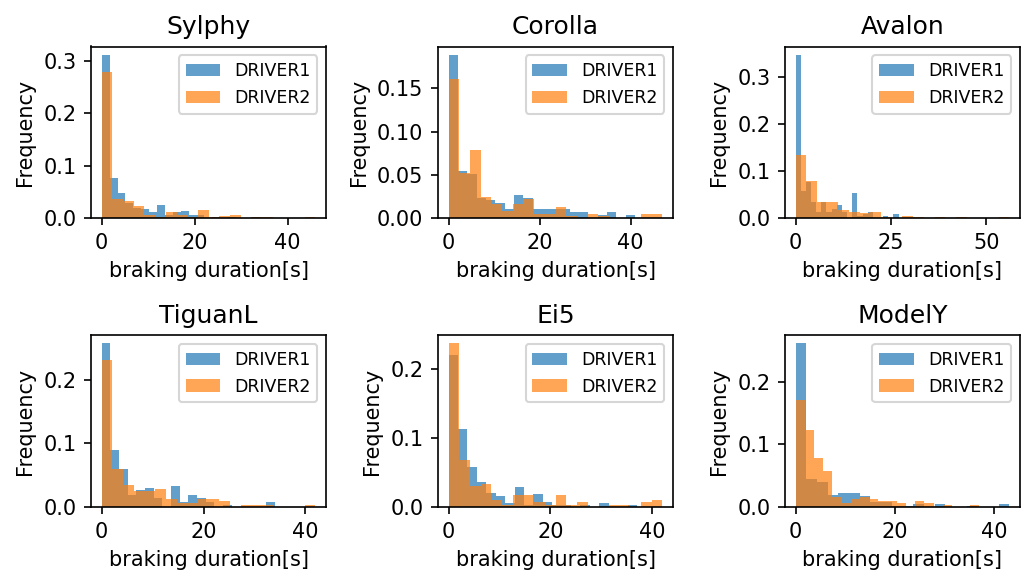

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,4))
axes = axes.flatten()

for i, model in enumerate(models):
    model_data = model_driver_events[model_driver_events['model'] == model]
    driver_1_data = model_data[model_data['driver'] == drivers[0]]['braking_t[s]']
    driver_2_data = model_data[model_data['driver'] == drivers[1]]['braking_t[s]']

    axes[i].hist(driver_1_data, bins=20, density=True, alpha=0.7, label=drivers[0])
    axes[i].hist(driver_2_data, bins=20, density=True, alpha=0.7, label=drivers[1])
    axes[i].set_title(model)
    axes[i].set_xlabel('braking duration[s]')
    axes[i].set_ylabel('Density')
    axes[i].legend(fontsize='small')

plt.tight_layout()
plt.show()

## 2 Impact of weight

In [159]:
model_mean = model_driver_events[['model', 'braking_t[s]', 'init_speed[km/h]', 'decel[m/s2]', 'weight']].groupby(by=['model']).mean()
model_mean = model_mean.sort_values(by='weight').reset_index()
model_mean['weight'] += 120

In [200]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(model_mean['weight'], model_mean['decel[m/s2]'])

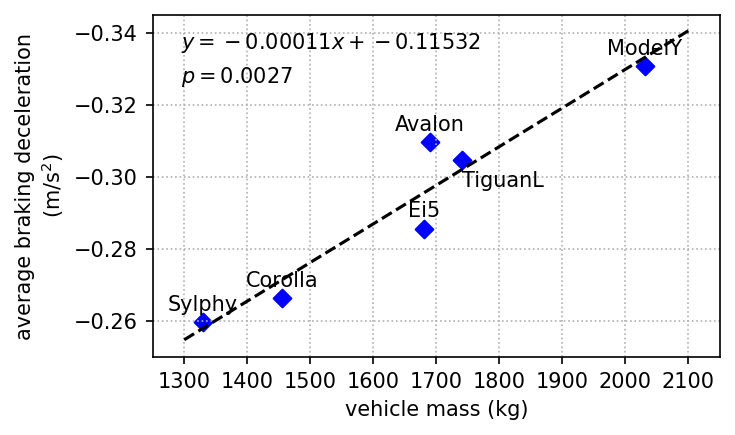

In [229]:
fig, axes = plt.subplots(1,1,figsize=(5,3))

# data point
plt.scatter(model_mean['weight'], model_mean['decel[m/s2]'], marker='D', color='blue')
for model in model_mean['model'].unique():
    data = model_mean[model_mean['model'] == model].iloc[0]
    if model == 'TiguanL':
        plt.text(data['weight'], data['decel[m/s2]']+0.003, model, va='top', ha='left')
    else:
        plt.text(data['weight'], data['decel[m/s2]']-0.002, model, va='bottom', ha='center')

# fitted line
x_fit = np.linspace(1300, 2100, 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, linestyle='--', color='k')
equation = f'$y={slope:.5f}x+{intercept:.5f}$'
plt.text(0.05, 0.9, equation, color='k',  transform=plt.gca().transAxes)
plt.text(0.05, 0.8, f'$p = {p_value:.4f}$', color='k', transform=plt.gca().transAxes)

plt.xlim(1250,2150)
plt.ylim(-0.345, -0.25)
plt.xlabel("vehicle mass (kg)")
plt.ylabel("average braking deceleration\n(m/s$^2$)")

plt.grid(linestyle=":")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 2 Impact of regenerative braking

### 2.1 Amount

In [9]:
model_driver['reg_ratio'] = model_driver['reg_braking_t[s]'] / model_driver['braking_t[s]']
model_driver['reg_ratio'] 

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.468303
9     0.348469
10    0.995327
11    0.973291
Name: reg_ratio, dtype: float64

### 2.2 Intensity

In [323]:
braking = model_driver_events[(model_driver_events['reg_braking_t[s]'] == 0)]
reg_braking_Ei5 = model_driver_events[(model_driver_events['model'] == 'Ei5') & (model_driver_events['reg_braking_t[s]'] != 0)]
reg_braking_ModelY = model_driver_events[(model_driver_events['model'] == 'ModelY') & (model_driver_events['reg_braking_t[s]'] != 0)]

In [324]:
print("Mean decel of braking: %.4f m/s$^2$" % braking['decel[m/s2]'].mean())
print("Mean decel of reg_braking_Ei5: %.4f m/s$^2$" % reg_braking_Ei5['decel[m/s2]'].mean())
print("Mean decel of reg_braking_ModelY: %.4f m/s$^2$" % reg_braking_ModelY['decel[m/s2]'].mean())

Mean decel of braking: -0.2627 m/s$^2$
Mean decel of reg_braking_Ei5: -0.3510 m/s$^2$
Mean decel of reg_braking_ModelY: -0.3961 m/s$^2$


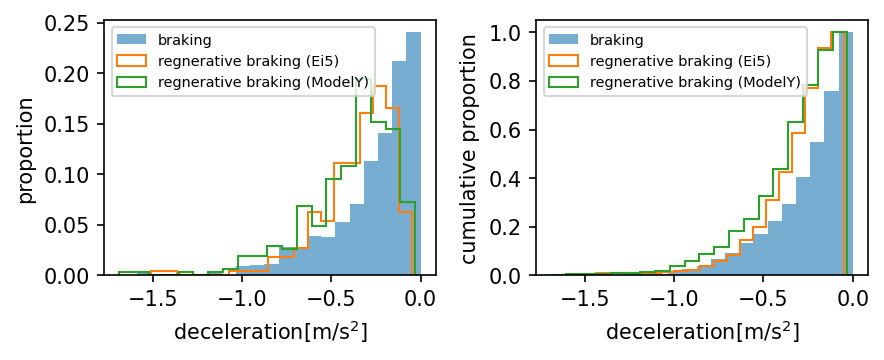

In [277]:
fig, axes = plt.subplots(1,2, figsize=(6,2.5))

data1 = braking['decel[m/s2]']
data2 = reg_braking_Ei5['decel[m/s2]']
data3 = reg_braking_ModelY['decel[m/s2]']
axes[0].hist(data1, bins=20, weights=1/len(data1)*np.ones(len(data1)), histtype='stepfilled', alpha=0.6, label='braking')
axes[0].hist(data2, bins=20, weights=1/len(data2)*np.ones(len(data2)), histtype='step', alpha=1, label='regnerative braking (Ei5)')
axes[0].hist(data3, bins=20, weights=1/len(data3)*np.ones(len(data3)), histtype='step', alpha=1, label='regnerative braking (ModelY)')
axes[0].set_xlabel('deceleration[m/s$^2$]')
axes[0].set_ylabel('proportion')
axes[0].legend(fontsize='x-small')

axes[1].hist(data1, bins=20, weights=1/len(data1)*np.ones(len(data1)), cumulative=True, histtype='stepfilled', alpha=0.6, label='braking')
axes[1].hist(data2, bins=20, weights=1/len(data2)*np.ones(len(data2)), cumulative=True, histtype='step', alpha=1, label='regnerative braking (Ei5)')
axes[1].hist(data3, bins=20, weights=1/len(data3)*np.ones(len(data3)), cumulative=True, histtype='step', alpha=1, label='regnerative braking (ModelY)')
axes[1].set_xlabel('deceleration[m/s$^2$]')
axes[1].set_ylabel('cumulative proportion')
axes[1].legend(fontsize='x-small')

plt.tight_layout()
plt.show()

In [31]:
braking_ei5 = decel_set[(decel_set['model'] == 'Ei5') & (decel_set['braking'] == 1) & (decel_set['reg'] == 0)].copy()
braking_modely = decel_set[(decel_set['model'] == 'ModelY') & (decel_set['braking'] == 1) & (decel_set['reg'] == 0)].copy()
braking_icev = decel_set[(~decel_set['model'].isin(['Ei5', 'ModelY'])) & (decel_set['braking'] == 1)].copy()

In [32]:
print("Mean decel of icev braking: %.4f m/s$^2$" % braking_icev['acc[m/s2]'].mean())
print("Mean decel of ei5 braking: %.4f m/s$^2$" % braking_ei5['acc[m/s2]'].mean())
print("Mean decel of modely braking: %.4f m/s$^2$" % braking_modely['acc[m/s2]'].mean())

Mean decel of icev braking: -0.6382 m/s$^2$
Mean decel of ei5 braking: -0.6917 m/s$^2$
Mean decel of modely braking: -1.6753 m/s$^2$


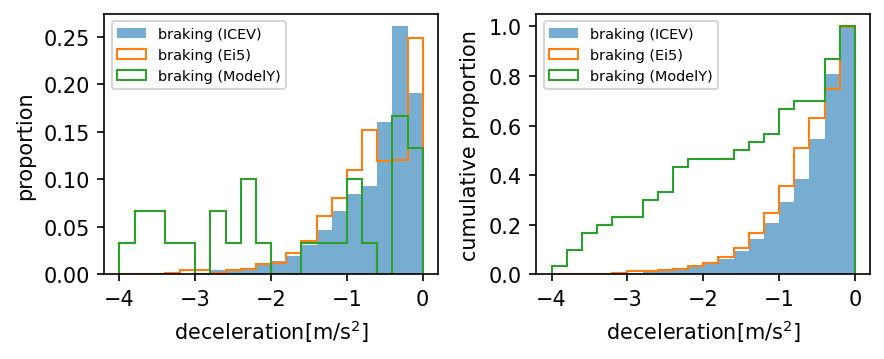

In [39]:
fig, axes = plt.subplots(1,2, figsize=(6,2.5))

data1 = braking_icev['acc[m/s2]']
data2 = braking_ei5['acc[m/s2]']
data3 = braking_modely['acc[m/s2]']
bins = np.arange(-4,0.1,0.2)
axes[0].hist(data1, bins=bins, weights=1/len(data1)*np.ones(len(data1)), histtype='stepfilled', alpha=0.6, label='braking (ICEV)')
axes[0].hist(data2, bins=bins, weights=1/len(data2)*np.ones(len(data2)), histtype='step', alpha=1, label='braking (Ei5)')
axes[0].hist(data3, bins=bins, weights=1/len(data3)*np.ones(len(data3)), histtype='step', alpha=1, label='braking (ModelY)')
# axes[0].set_xlim(-2,0)
axes[0].set_xlabel('deceleration[m/s$^2$]')
axes[0].set_ylabel('proportion')
axes[0].legend(fontsize='x-small')

axes[1].hist(data1, bins=bins, weights=1/len(data1)*np.ones(len(data1)), cumulative=True, histtype='stepfilled', alpha=0.6, label='braking (ICEV)')
axes[1].hist(data2, bins=bins, weights=1/len(data2)*np.ones(len(data2)), cumulative=True, histtype='step', alpha=1, label='braking (Ei5)')
axes[1].hist(data3, bins=bins, weights=1/len(data3)*np.ones(len(data3)), cumulative=True, histtype='step', alpha=1, label='braking (ModelY)')
# axes[1].set_xlim(-2,0)
axes[1].set_xlabel('deceleration[m/s$^2$]')
axes[1].set_ylabel('cumulative proportion')
axes[1].legend(fontsize='x-small')

plt.tight_layout()
plt.show()

## 3 Impact of road types

In [125]:
highway_types = ['motorway','motorway_link','primary','secondary','trunk','trunk_link']

### 3.1 Amount

In [281]:
all_dfs = []
for key, df in trajs.items():
    all_dfs.append(df)
combined_df = gpd.GeoDataFrame(pd.concat(all_dfs, ignore_index=True))

# replace wrong highway types
combined_df['highway'] = combined_df['highway'].replace({"trunk":'primary', "trunk_link":'primary', "tertiary":"secondary"})
model_driver_events['highway'] = model_driver_events['highway'].replace({"trunk":'primary', "trunk_link":'primary', "tertiary":"secondary"})

In [295]:
braking_time = model_driver_events[['highway', 'braking_t[s]']].groupby(by='highway').sum()
braking_event = model_driver_events[['highway', 'event_id']].groupby(by='highway').apply(lambda group: len(group))
total_time = combined_df[['highway', 'sec']].groupby(by='highway').apply(lambda group: len(group))
total_mileage = combined_df[['highway', 'd_gap[m]']].groupby(by='highway').sum()

highway_amount = pd.concat([braking_time, braking_event, total_time, total_mileage], axis=1)
highway_amount.columns = ['braking_t[s]', 'braking_n', 'duration[s]', 'mileage[m]']
highway_amount['braking_frac'] = highway_amount['braking_t[s]'] / highway_amount['duration[s]']
highway_amount['braking_freq'] = highway_amount['braking_n'] / highway_amount['mileage[m]'] * 1000
highway_amount

,braking_t[s],braking_n,duration[s],mileage[m],braking_frac,braking_freq
highway,,,,,,
motorway,621,331,5107,132008.456399,0.121598,2.507415
motorway_link,1051,208,3322,37224.945865,0.316376,5.587651
primary,4503,747,13714,116329.677311,0.328351,6.421405
secondary,5304,748,18561,151774.437575,0.285760,4.928366


### 3.2 Intensity

In [296]:
model_driver_events.groupby('highway')[['init_speed[km/h]', 'decel[m/s2]', 'braking_t[s]']].mean()

,init_speed[km/h],decel[m/s2],braking_t[s]
highway,,,
motorway,94.898459,-0.158137,1.876133
motorway_link,47.523460,-0.273257,5.052885
primary,44.059496,-0.323719,6.028112
secondary,50.229586,-0.325777,7.090909


## 4 Impact of speed

### Amount

In [317]:
# speed bins
model_driver_events['speed_bin'] = pd.cut(model_driver_events['init_speed[km/h]'], bins=np.arange(0,130,10))
combined_df['speed_bin'] = pd.cut(combined_df['speed[km/h]'], bins=np.arange(0,130,10))

In [337]:
braking_time = model_driver_events[['speed_bin', 'braking_t[s]']].groupby(by='speed_bin').sum()
braking_event = model_driver_events[['speed_bin', 'event_id']].groupby(by='speed_bin').apply(lambda group: len(group))
total_time = combined_df[['speed_bin', 'sec']].groupby(by='speed_bin').apply(lambda group: len(group))
total_mileage = combined_df[['speed_bin', 'd_gap[m]']].groupby(by='speed_bin').sum()

speed_bin_amount = pd.concat([braking_time, braking_event, total_time, total_mileage], axis=1)
speed_bin_amount.columns = ['braking_t[s]', 'braking_n', 'duration[s]', 'mileage[m]']
speed_bin_amount['braking_frac'] = speed_bin_amount['braking_t[s]'] / speed_bin_amount['duration[s]']
speed_bin_amount['braking_freq'] = speed_bin_amount['braking_n'] / speed_bin_amount['mileage[m]'] * 1000
speed_bin_amount.reset_index(inplace=True)

### Intensity

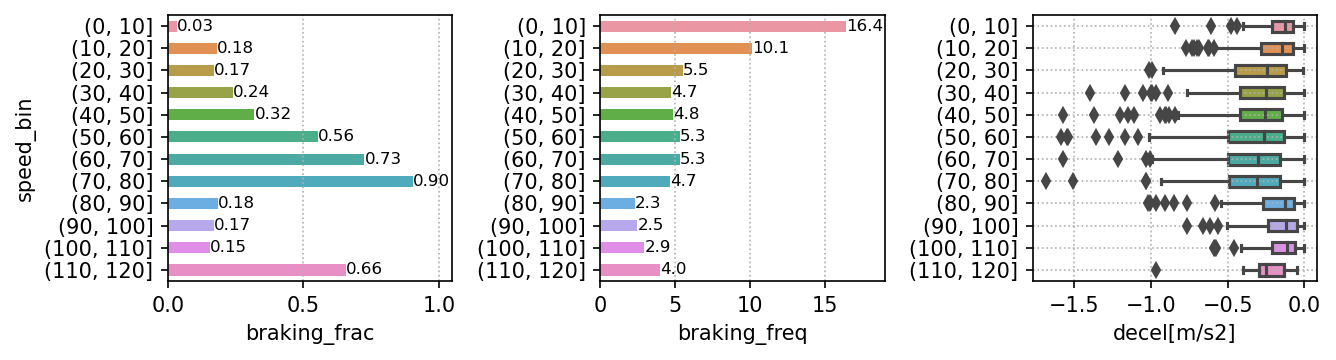

In [354]:
import seaborn as sns

fig, axes = plt.subplots(1,3, figsize=(9,2.5))

# fig1: braking fraction
sns.barplot(data=speed_bin_amount, y='speed_bin', x='braking_frac', width=0.5, orient='h', ax=axes[0])
for p in axes[0].patches:
    width = p.get_width()
    axes[0].text(width, p.get_y() + p.get_height() / 2., '{:1.2f}'.format(width), fontsize=8, ha='left', va='center')
axes[0].grid(axis="x", linestyle=":")
axes[0].set_xlim(0, 1.05)

# fig2: braking frequency
sns.barplot(data=speed_bin_amount, y='speed_bin', x='braking_freq', width=0.5, orient='h', ax=axes[1])
for p in axes[1].patches:
    width = p.get_width()
    axes[1].text(width, p.get_y() + p.get_height() / 2., '{:.1f}'.format(width), fontsize=8, ha='left', va='center')
axes[1].set_ylabel("")
axes[1].grid(axis="x", linestyle=":")
axes[1].set_xlim(0, 19)

# fig3: decel
sns.boxplot(data=model_driver_events, y='speed_bin', x='decel[m/s2]', width=0.5, orient='h', ax=axes[2])
axes[2].set_ylabel("")
axes[2].grid(linestyle=":")

plt.tight_layout()
plt.show()

---

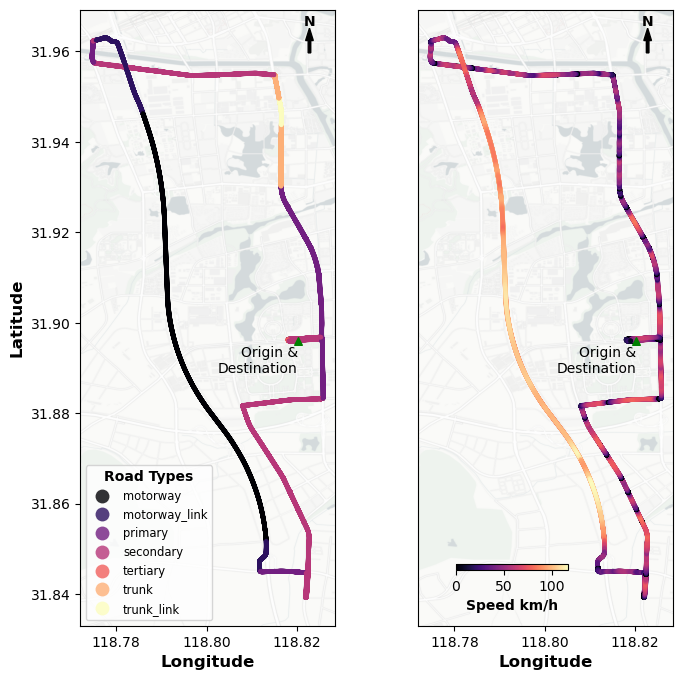

In [17]:
import contextily as ctx
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(8,8))

# transfer to geodataframe
all_gdfs = []
for key, df in trajs.items():
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']))
    gdf.crs = 'EPSG:4326'
    all_gdfs.append(gdf)
combined_gdf = gpd.GeoDataFrame(pd.concat(all_gdfs, ignore_index=True))

# plot trajectory
combined_gdf.plot(
    ax=ax1, column='highway', markersize=5, alpha=0.8, cmap='magma',
    legend=True, legend_kwds={
        'title':'Road Types', 'title_fontproperties':{'weight':'bold'},
        'loc':'lower left', 'fontsize':'small'
})

# plot speed
im = combined_gdf.plot(
    ax=ax2, column='speed[km/h]', markersize=5, alpha=0.8, cmap='magma',
    legend=True, legend_kwds={
        'location':'bottom', 'orientation':'horizontal',
        'fraction':0.1, 'pad':-0.1, 'anchor':(0.3,1), 'shrink':0.4,
        'ticks':[0,50,100],
})
cbar = im.get_figure().axes[-1]
cbar.set_xlabel('Speed km/h', fontweight='bold')

# start point and end point
first_trajectory = all_gdfs[0]
start_point = first_trajectory.iloc[0]
ax1.scatter(start_point.geometry.x, start_point.geometry.y, marker='^', color='green', s=30)
ax1.text(start_point.geometry.x, start_point.geometry.y-0.001, 'Origin &\nDestination', fontsize=10, color='black',
         horizontalalignment='right', verticalalignment='top')
ax2.scatter(start_point.geometry.x, start_point.geometry.y, marker='^', color='green', s=30)
ax2.text(start_point.geometry.x, start_point.geometry.y-0.001, 'Origin &\nDestination', fontsize=10, color='black',
         horizontalalignment='right', verticalalignment='top')

# basemap
ctx.add_basemap(ax1, crs=combined_gdf.crs.to_string(), source="https://d.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png")
ctx.add_basemap(ax2, crs=combined_gdf.crs.to_string(), source="https://d.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png")

# arrow
def add_north_arrow(ax, x, y, arrow_length, text='N', text_offset=0.03):
    ax.arrow(x, y, 0, arrow_length, transform=ax.transAxes,
             facecolor='black', edgecolor='black', width=0.01, head_width=0.03, head_length=0.02)
    ax.text(x, y + arrow_length + text_offset, text, transform=ax.transAxes,
            ha='center', va='center', fontsize=10, fontweight='bold')
add_north_arrow(ax1, 0.9, 0.93, 0.02)
add_north_arrow(ax2, 0.9, 0.93, 0.02)

# axis
ax1.set_xticks([118.78, 118.80, 118.82])
ax1.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax1.set_ylabel('Latitude', fontsize=12, fontweight='bold')
ax2.set_xticks([118.78, 118.80, 118.82])
ax2.set_yticks([])
ax2.set_xlabel('Longitude', fontsize=12, fontweight='bold')

plt.show()

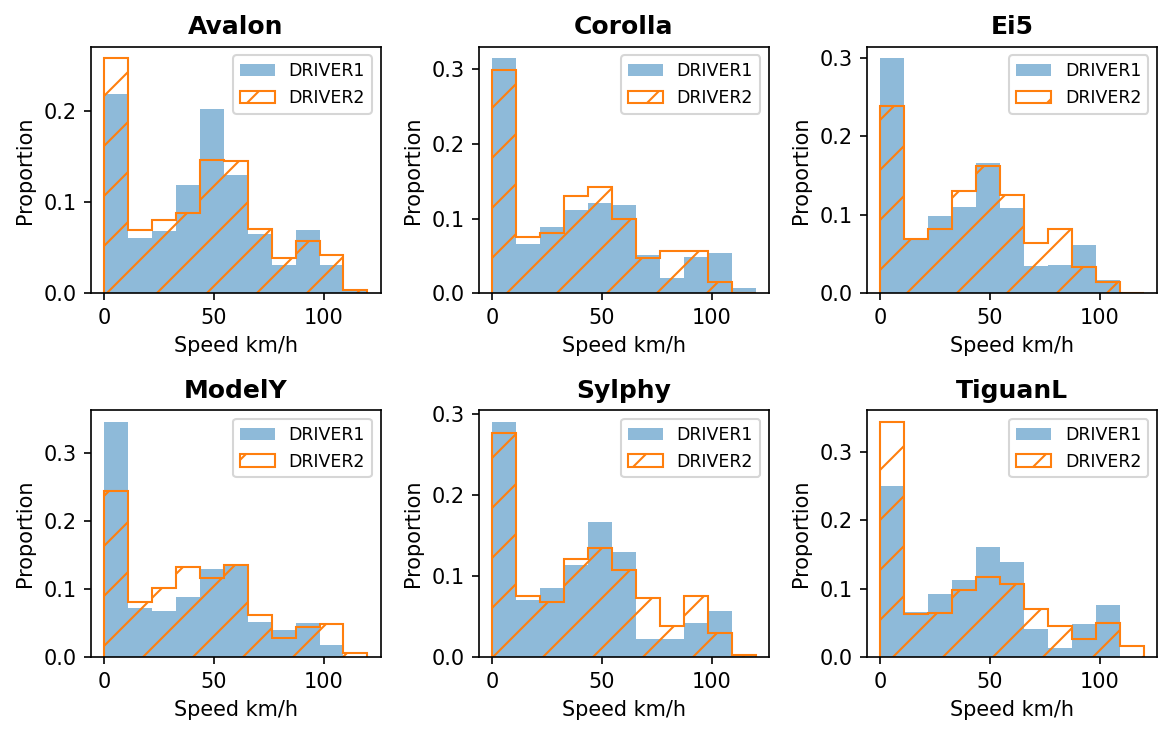

In [167]:
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
axes = axes.flatten()

models = trip_data['model'].unique()
drivers = trip_data['driver'].unique()
bins = np.linspace(0, 120, 12)

for i, model in enumerate(models):
    ax = axes[i]
    # speed data
    driver1_key = f'{model}-{drivers[0]}'
    driver2_key = f'{model}-{drivers[1]}'
    driver1_data = trajs[driver1_key]['speed[km/h]']
    driver2_data = trajs[driver2_key]['speed[km/h]']
    # speed distribution
    driver1_hist, _ = np.histogram(driver1_data, bins=bins)
    driver2_hist, _ = np.histogram(driver2_data, bins=bins)
    ax.stairs(driver1_hist/len(driver1_data), bins, label=drivers[0], fill=True, alpha=0.5)
    ax.stairs(driver2_hist/len(driver2_data), bins, label=drivers[1], fill=False, alpha=1.0, hatch='/')
    # axis
    ax.set_title(model, fontweight='bold')
    ax.set_xlabel('Speed km/h')
    ax.set_ylabel('Proportion')
    ax.legend(fontsize='small')
plt.tight_layout()
plt.show()

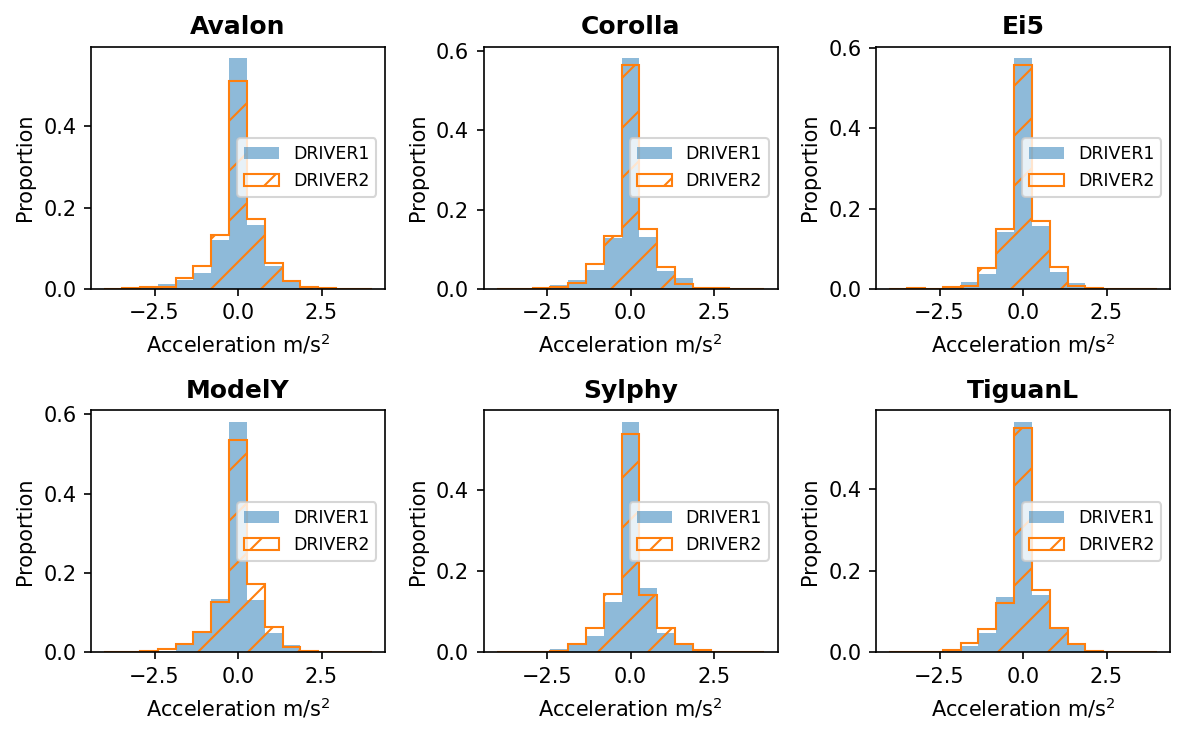

In [164]:
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
axes = axes.flatten()

models = trip_data['model'].unique()
drivers = trip_data['driver'].unique()
bins = np.linspace(-4, 4, 16)

for i, model in enumerate(models):
    ax = axes[i]
    # speed data
    driver1_key = f'{model}-{drivers[0]}'
    driver2_key = f'{model}-{drivers[1]}'
    driver1_data = trajs[driver1_key]['acc[m/s2]']
    driver2_data = trajs[driver2_key]['acc[m/s2]']
    # speed distribution
    driver1_hist, _ = np.histogram(driver1_data, bins=bins)
    driver2_hist, _ = np.histogram(driver2_data, bins=bins)
    ax.stairs(driver1_hist/len(driver1_data), bins, label=drivers[0], fill=True, alpha=0.5)
    ax.stairs(driver2_hist/len(driver2_data), bins, label=drivers[1], fill=False, alpha=1.0, hatch='/')
    # axis
    ax.set_title(model, fontweight='bold')
    ax.set_xlabel('Acceleration m/s$^2$')
    ax.set_ylabel('Proportion')
    ax.legend(fontsize='small')
plt.tight_layout()
plt.show()

In [168]:
def plot_explore(key):

    # traj
    traj = trajs[key]
    test_traj = traj.copy()

    # plot
    fig, ax = plt.subplots(1,1, figsize=(15,3))
    ax.stairs(test_traj['speed[km/h]'], color='blue', linewidth=0.5, fill=False, alpha=1.0, label="speed [km/h]")
    ax.stairs(test_traj['pad_pressure'].apply(lambda x: np.log(x) if x > 0 else 0), color='red', linewidth=0.5, fill=False, alpha=0.8, label="brake pad signal (log)")
    ax.stairs(test_traj['trac_power[kW]'], color='green', linewidth=0.5, fill=True, alpha=0.5, label="tractive power [kW]")
    ax.set_title(key)
    ax.set_xlim(0, 3200)
    ax.set_ylim(-20,120)
    ax.legend()
    fig.savefig('fig/explore/%s.jpg' % key)
    plt.show()

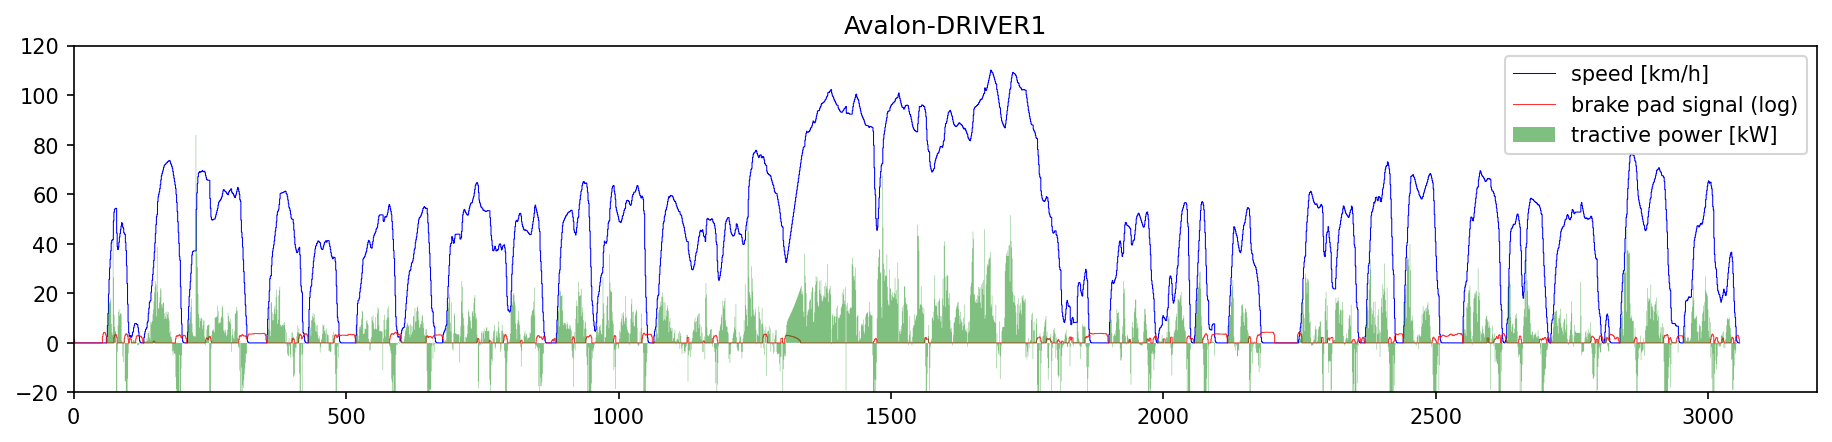

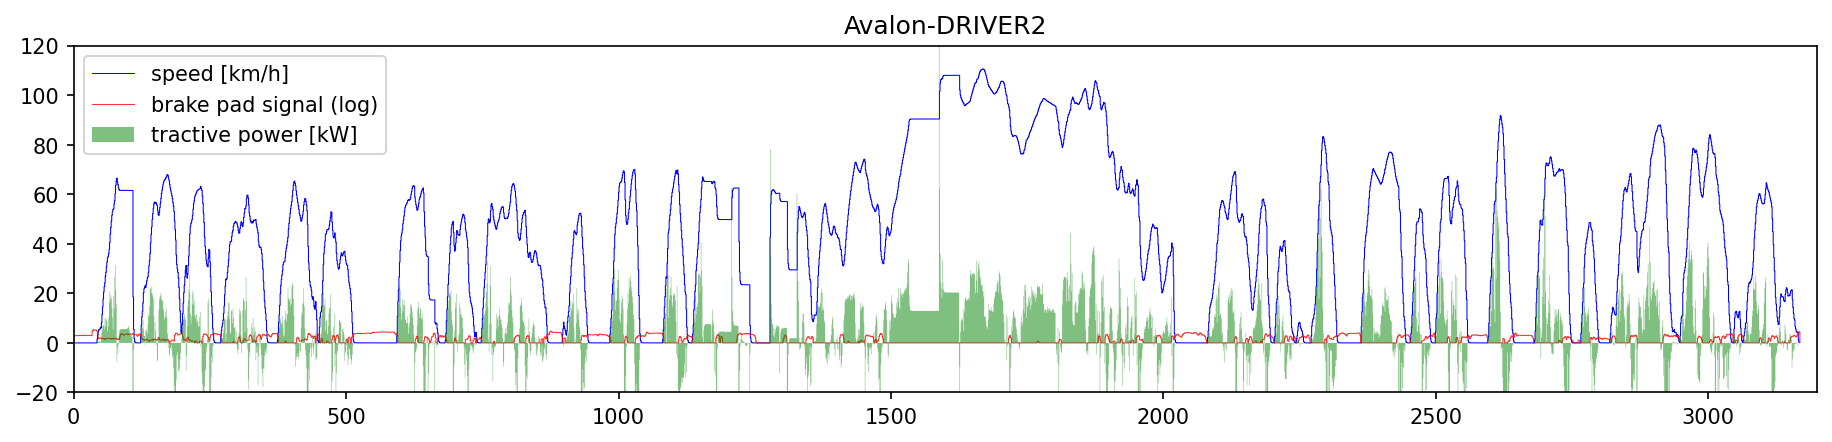

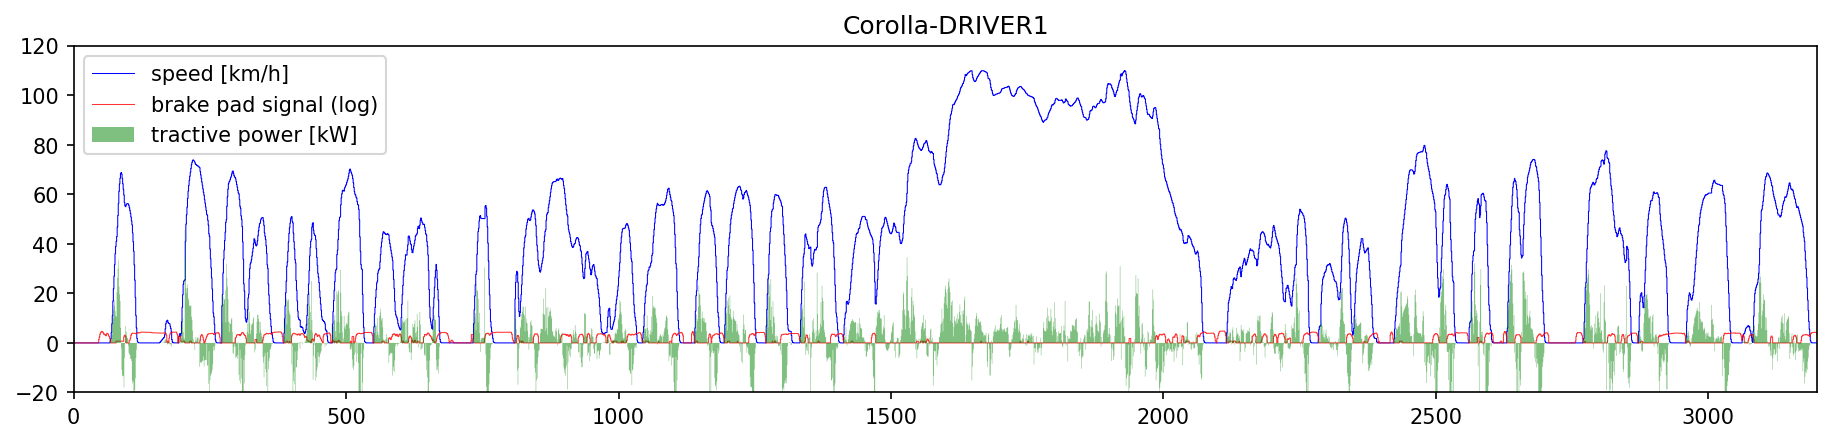

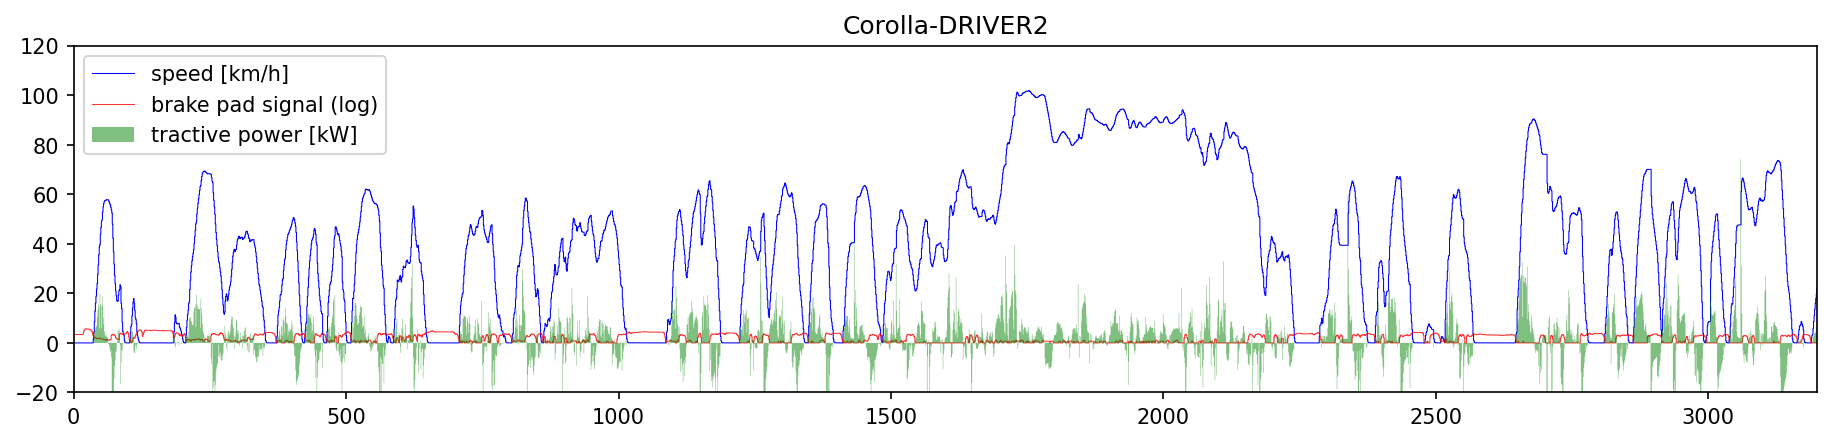

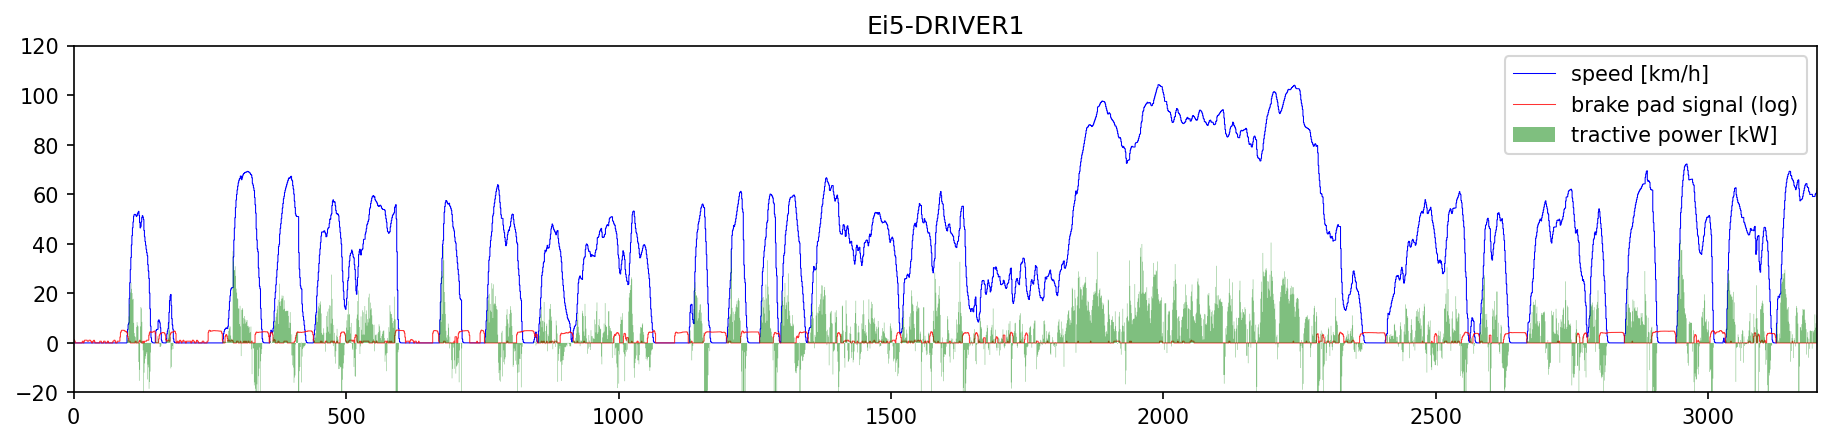

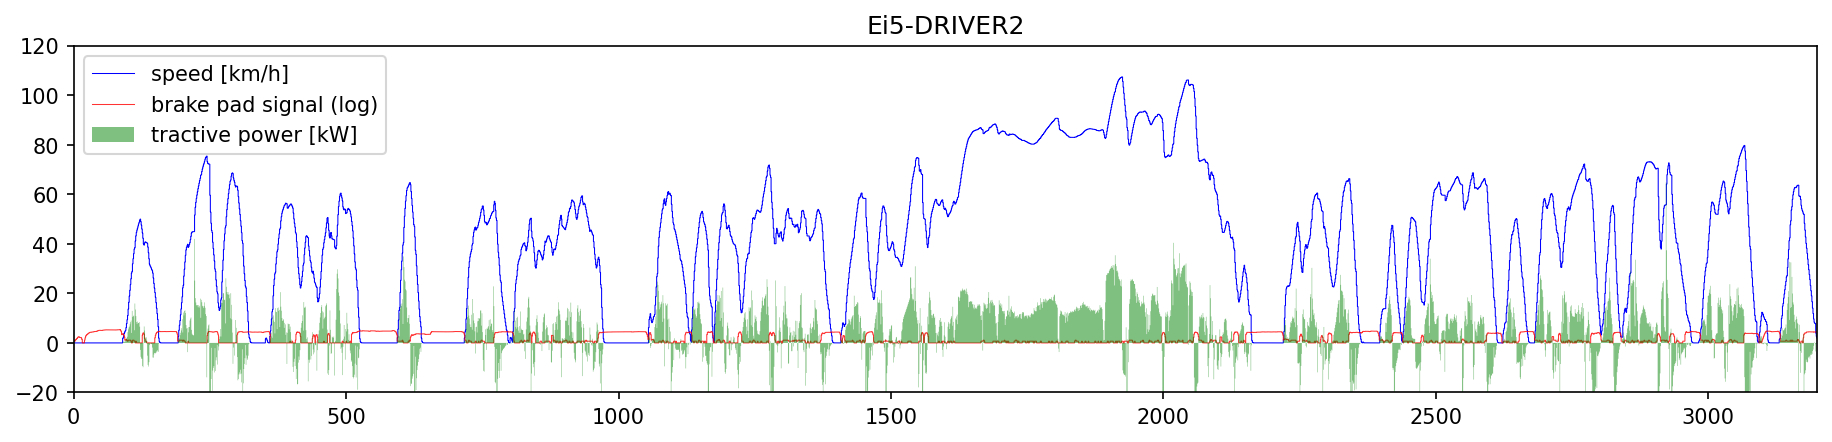

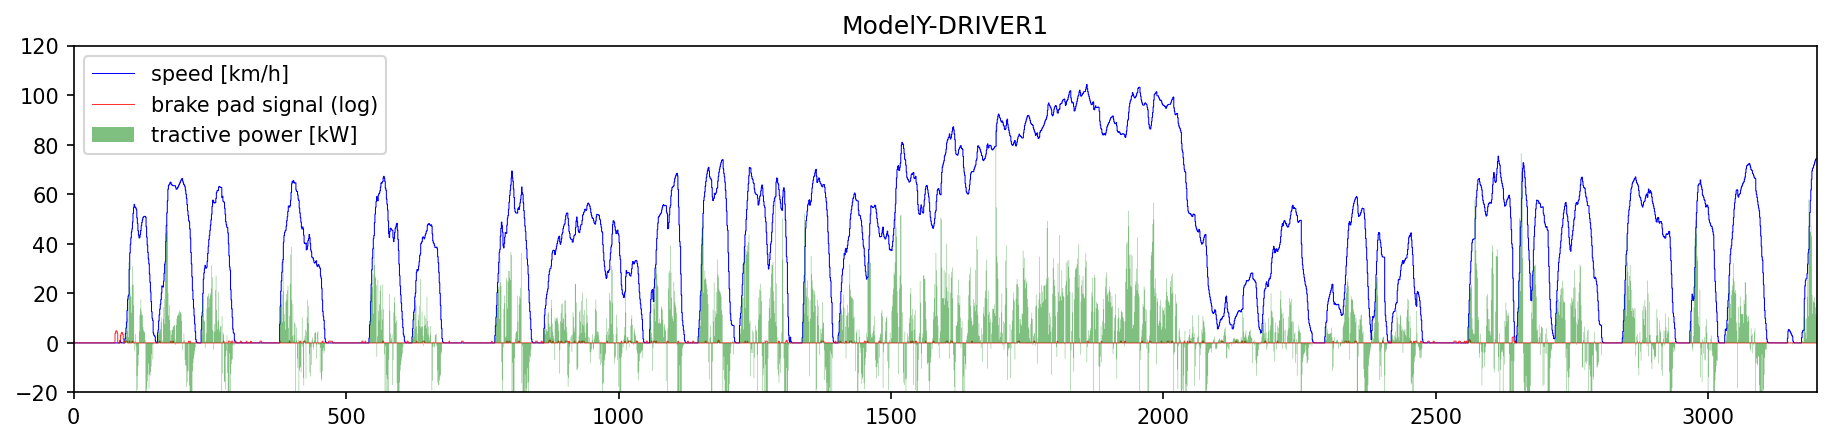

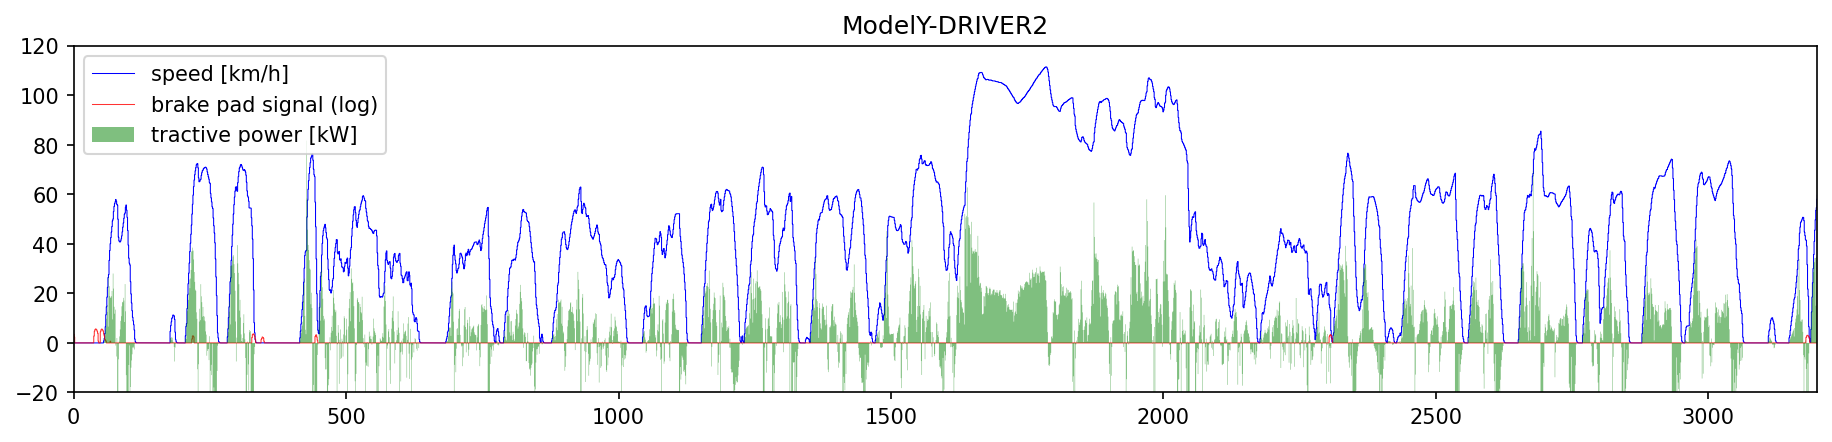

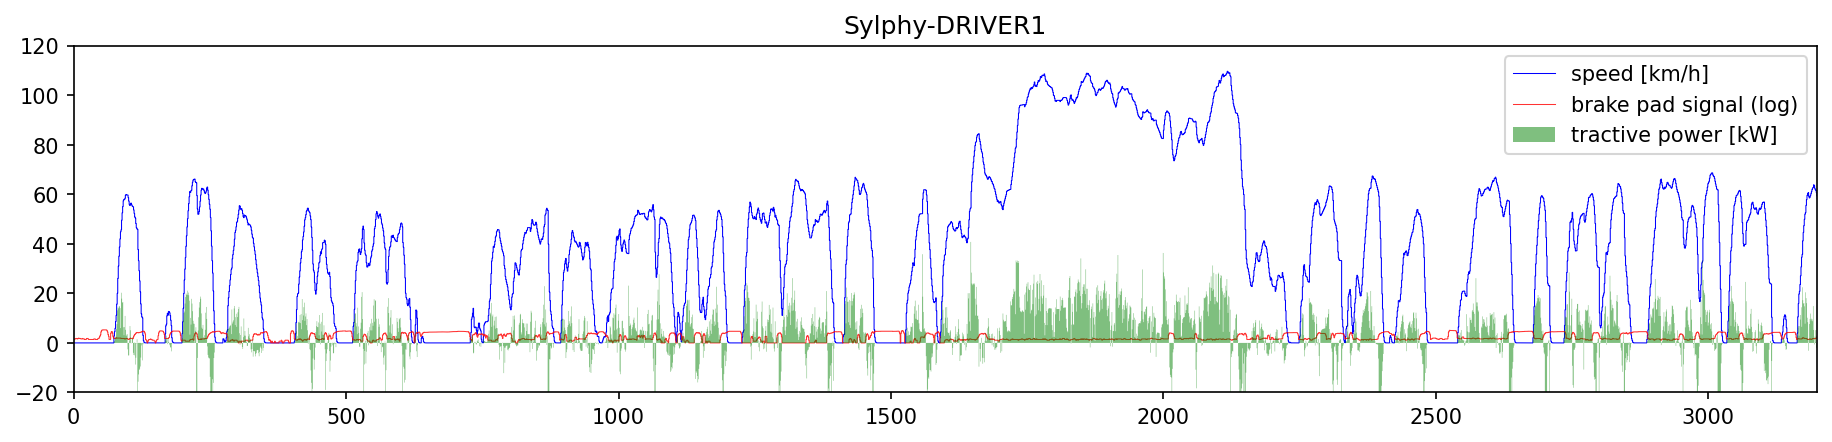

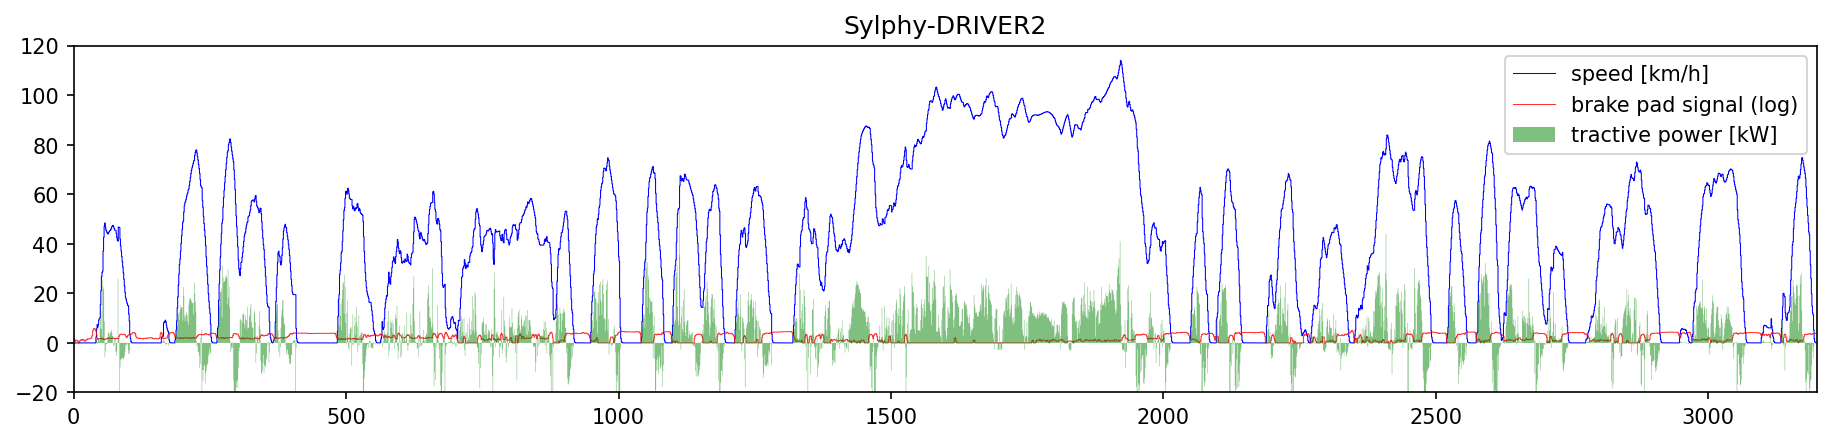

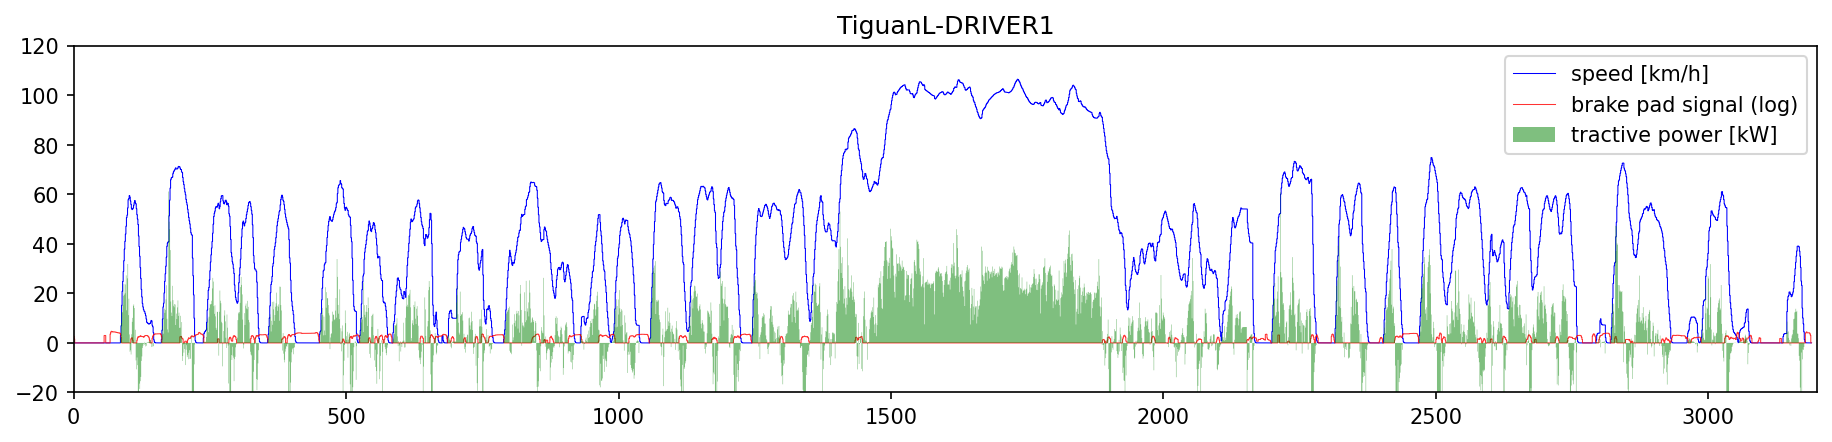

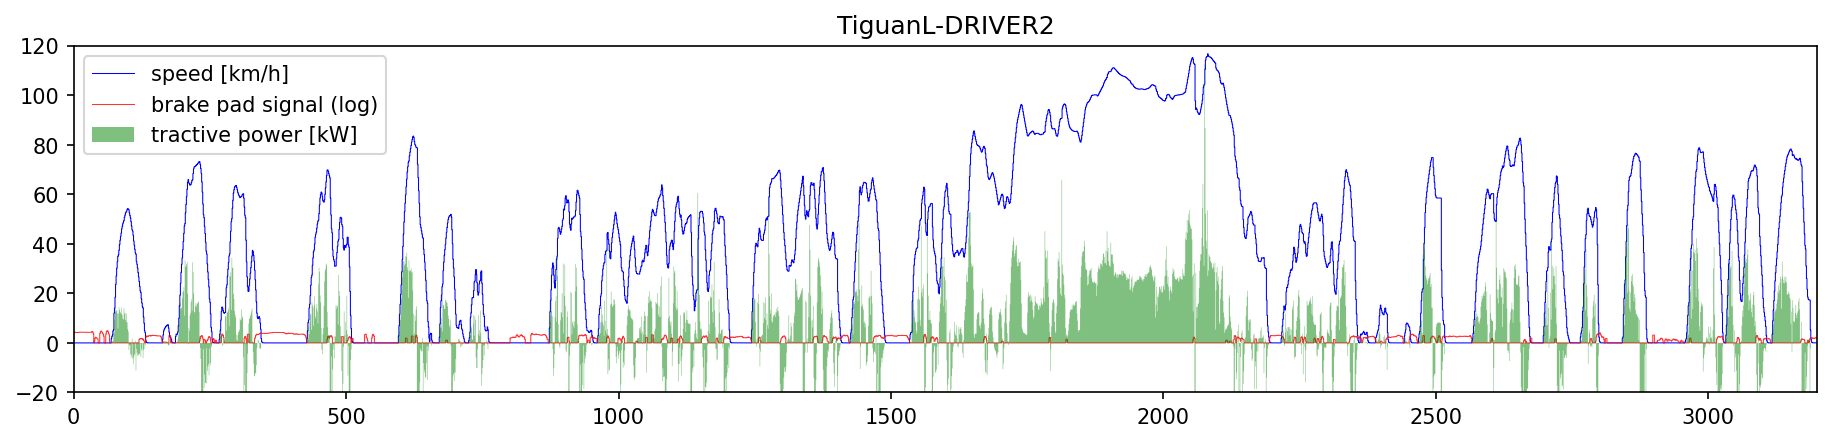

In [169]:
for key in trajs.keys():
    plot_explore(key)